# Advance Lane Detection

In [12]:
import numpy as np
import cv2

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_image(img):
    # debug function to easily display and test image
    plt.figure()
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elif len(img.shape) == 3 and img.shape[2] == 1:
        plt.imshow(img[:,:,0],cmap='gray')
    else:
        plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

## Camera Calibration

In [53]:
CALIBRATION_DIR = 'camera_cal/'
CALIBRATION_MASK = 'calibration*.jpg'
GRID_X=9
GRID_Y=6

In [56]:
import json
import glob
import os.path

class Camera:
    def __init__(self, name = 'camera'):
        self.name = name
        self.camera_matrix = None
        self.dist_coeffs = None
        
    def calibrate(self, path_mask, grid_x, grid_y):
        # try loading the results from a previous calibration
        if self.load():
            return True
        
        # calibrate the camera
        print('Calibrating camera using images from ' + path_mask)
        
        objpoints = []
        imgpoints = []
        img_shape = None

        # prepare object points
        objp = np.zeros((grid_x*grid_y,3), np.float32)
        objp[:,:2] = np.mgrid[0:grid_x,0:grid_y].T.reshape(-1, 2)
                
        # process all calibration images
        for filename in glob.glob(path_mask):
            
            print ('... processing image ' + filename, end='')

            img = cv2.imread(filename)
    
            # skip invalid images
            if img is None:
                continue
        
            if img_shape is None:
                img_shape = img.shape[0:2]
    
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
            found, corners = cv2.findChessboardCorners(gray, (grid_x, grid_y), None)
    
            if found: 
                objpoints.append(objp)
                imgpoints.append(corners)
                print(' ... OK')
            else:
                print(' ... skipped')
    
        # end for (filenames)
        
        # compute camera-matrix and distance coefficients
        cal_ok, self.camera_matrix, self.dist_coeffs, rvecs, tvecs = \
            cv2.calibrateCamera(objpoints, imgpoints, img_shape[0:2], None, None)

        if cal_ok:
            self.save()
            return True
        
        return False
    
    def undistort(self, src_img):
        return cv2.undistort(src_img, self.camera_matrix, self.dist_coeffs, None, self.camera_matrix)
        
    def save(self):
        with open(self.name + '.json', 'w') as f:
            json.dump({'matrix' : self.camera_matrix.tolist(),
                       'dist' : self.dist_coeffs.tolist()}, f)
    
    def load(self):
        if not os.path.isfile(self.name + '.json'):
            return False
    
        print('Loading calibration data')
        with open(self.name + '.json', 'r') as f:
            data = json.load(f)
            self.camera_matrix = np.array(data['matrix'])
            self.dist_coeffs = np.array(data['dist'])
            return True
            
        

In [57]:
camera = Camera('camera_udacity')
if not camera.calibrate(CALIBRATION_DIR + CALIBRATION_MASK, GRID_X, GRID_Y):
    print ("ERROR CALIBRATING CAMERA")

Loading calibration data


## Undistort

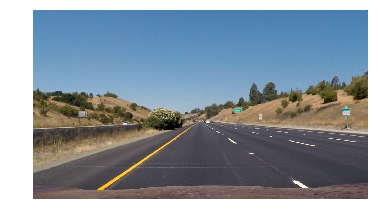

In [63]:
img = cv2.imread('test_images/straight_lines1.jpg')
display_image(img)

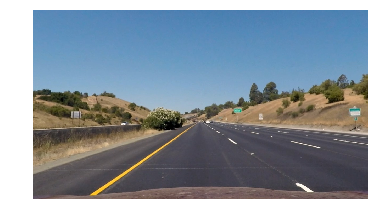

In [66]:
corrected = camera.undistort(img)
cv2.imwrite('corrected.jpg', corrected)
display_image(corrected)

## Perspective transformation

In [116]:
class ImagePipeline:
    def __init__(self):
        self.compute_perspective_transform()
        pass
    
    def compute_perspective_transform(self):
        src_points = np.float32([[ 230, 700], 
                                 [ 560, 470], 
                                 [ 730, 470], 
                                 [1090, 700]])
        dst_points = np.float32([[ 350, 720], 
                                 [ 350,   0], 
                                 [ 980,   0], 
                                 [ 980, 720]])
        
        self.persp_M = cv2.getPerspectiveTransform(src_points, dst_points)
        self.persp_Minv = cv2.getPerspectiveTransform(dst_points, src_points)
        
    def transform_topdown(self, img):
        return cv2.warpPerspective(img, self.persp_M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
       
#example = np.copy(corrected)
#cv2.polylines(example, [np.int32(src_points)], True, [0, 0, 255], 5)
#display_image(example)


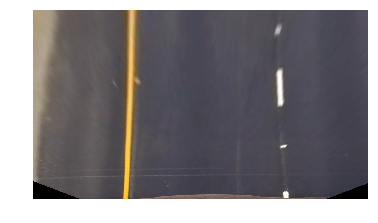

In [118]:
pipeline = ImagePipeline()

topdown = pipeline.transform_topdown(corrected)
display_image(topdown)
